In [194]:
# Import drive and connect
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Check GPU
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [160]:
# import main modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, classification_report


In [28]:
# download and import packages for reading .tif files

!pip install pyrsgis
!pip install matplotlib_scalebar
from pyrsgis import raster
from pyrsgis.convert import changeDimension

In [195]:
# define functions for use in the notebook - these should be moved to a separate file but making that work with colab is turning out to be a real headache

def removeTopRow(x):
    '''Something is off with the top row in the satellite data, remove it.'''
    if x.ndim == 2: x = np.delete(x, (0), axis=0)
    else: x = np.delete(x, (0), axis=1)

    return x

def normalizeBand(band):
    '''normalize band inputs to 0-1 for input into neural nets'''
    band_min, band_max = band.min(), band.max()
    return ((band - band_min)/(band_max - band_min))

def normalizeUInt16Band(band):
    '''Bands 1-7 are uint16, ranging from 0-65535, normalize them by dividing by the max.'''
    return band/65535.



In [196]:
# grab image file
training_image = "/content/drive/MyDrive/MangroveClassification/Images/Florida_1_2000.tif"

In [197]:
main_bands = [i+1 for i in range(0,7)]
ndvi_band = 9
labels_band = 8

# choose the input band(s)
input_bands = ndvi_band

# read in band data
ds_features, features = raster.read(training_image, bands=input_bands) # if just inputting one band, do NOT put the single number in a list to pass to "bands", it causes some issue under the hood
ds_labels, labels = raster.read(training_image, bands=labels_band)

# remove top row of data (which is bad)
features = removeTopRow(features)
labels = removeTopRow(labels)

# fill NaNs with 0s
features = np.nan_to_num(features)
labels = np.nan_to_num(labels)

# store the number of bands, which will be useful for inputting to the neural network later
if features.ndim == 2: nBands = 1
else: nBands = features.shape[0]
print('nBands: ', nBands)


nBands:  1


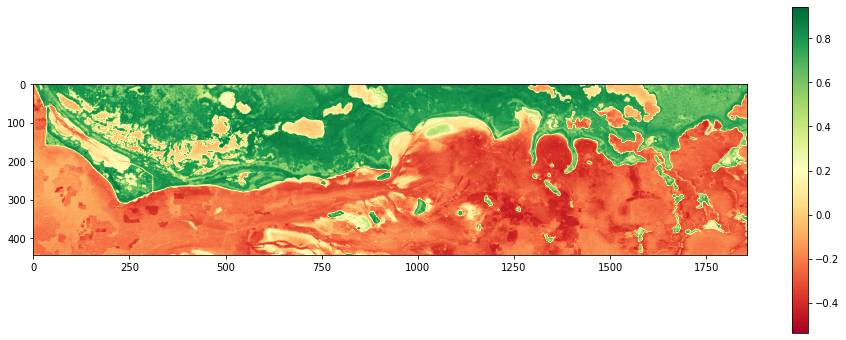

In [198]:
plt.figure(figsize=(16,6))
plt.imshow(features, cmap='RdYlGn')
plt.colorbar()
plt.show()

In [199]:
# change dimensions for input into neural net
features_input = changeDimension(features)
labels_input = changeDimension(labels)

print(features_input.shape)
print(labels_input.shape)

(828222,)
(828222,)


In [200]:
# convert labels to int for classification
labels_input = (labels_input == 1).astype(int)
labels_input

array([0, 0, 0, ..., 0, 0, 0])

In [201]:
# split the data
xTrain, xTest, yTrain, yTest = train_test_split(features_input, labels_input, test_size=0.4, random_state=42)

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

(496933,)
(496933,)
(331289,)
(331289,)


In [202]:
# normalize bands - don't really need to do this for the NDVI band, and probably want to use something separate for the other bands, which are already by default bounded
# probably also do not want to normalize differently between the train and test, since their bounds are independent of the samples
# xTrain = normalizeBand(xTrain)
# xTest = normalizeBand(xTest)

In [203]:
# Define the parameters of the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(2, activation='softmax')])

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [204]:
# fit the model
history = model.fit(xTrain, yTrain, validation_split=0.3, epochs=3)


Epoch 1/3
10871/10871 [==============================] - 15s 1ms/step - loss: 0.1756 - accuracy: 0.9367 - val_loss: 0.1027 - val_accuracy: 0.9604
Epoch 2/3
10871/10871 [==============================] - 15s 1ms/step - loss: 0.1050 - accuracy: 0.9591 - val_loss: 0.1009 - val_accuracy: 0.9610
Epoch 3/3
10871/10871 [==============================] - 15s 1ms/step - loss: 0.1022 - accuracy: 0.9601 - val_loss: 0.1008 - val_accuracy: 0.9609


In [205]:
print(history.history)

# fig, ax = plt.subplots()

# mae = history.history['mae']
# val_mae = history.history['val_mae']

# epochs = range(len(mae))

# ax.plot(epochs, mae, label='Train MAE')
# ax.plot(epochs, val_mae, label='Val MAE')

# ax.legend();

{'loss': [0.1229715421795845, 0.10378941148519516, 0.10262660682201385], 'accuracy': [0.9534515738487244, 0.9595173597335815, 0.9600578546524048], 'val_loss': [0.10266610980033875, 0.10091997683048248, 0.10083770006895065], 'val_accuracy': [0.9604440331459045, 0.9609538316726685, 0.9608867764472961]}


In [206]:
# Predict for test data 
yTest_pred = model.predict(xTest)
yTest_pred = yTest_pred[:,1] # grab probablities for class label 1

# # Calculate and display the error metrics
yTest_pred = (yTest_pred>0.5).astype(int) # convert prediction probabilities to 0 or 1 values depending on threshold
cMatrix = confusion_matrix(yTest, yTest_pred)
pScore = precision_score(yTest, yTest_pred)
rScore = recall_score(yTest, yTest_pred)
aScore = accuracy_score(yTest, yTest_pred)
f1Score = f1_score(yTest, yTest_pred)

print("Confusion matrix:\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f" % (pScore, rScore))
print('Accuracy: %.3f' % (aScore))
print('f1: %.3f' % (f1Score))

print(classification_report(yTest, yTest_pred))


Confusion matrix:
 [[224306   8894]
 [  3955  94134]]

P-Score: 0.914, R-Score: 0.960
Accuracy: 0.961
f1: 0.936
              precision    recall  f1-score   support

           0       0.98      0.96      0.97    233200
           1       0.91      0.96      0.94     98089

    accuracy                           0.96    331289
   macro avg       0.95      0.96      0.95    331289
weighted avg       0.96      0.96      0.96    331289



In [207]:
# load up a new image to test on
test_image = "/content/drive/MyDrive/MangroveClassification/Images/Florida_2_2000.tif"

# read in band data
ds_features_test, features_test = raster.read(test_image, bands=input_bands)
ds_labels_test, labels_test = raster.read(test_image, bands=labels_band)

# remove top row of data (which is bad)
features_test = removeTopRow(features_test)
labels_test = removeTopRow(labels_test)

# fill NaNs with 0s
features_test = np.nan_to_num(features_test)
labels_test = np.nan_to_num(labels_test)

# change label from float to int
labels_test = (labels_test == 1).astype(int)

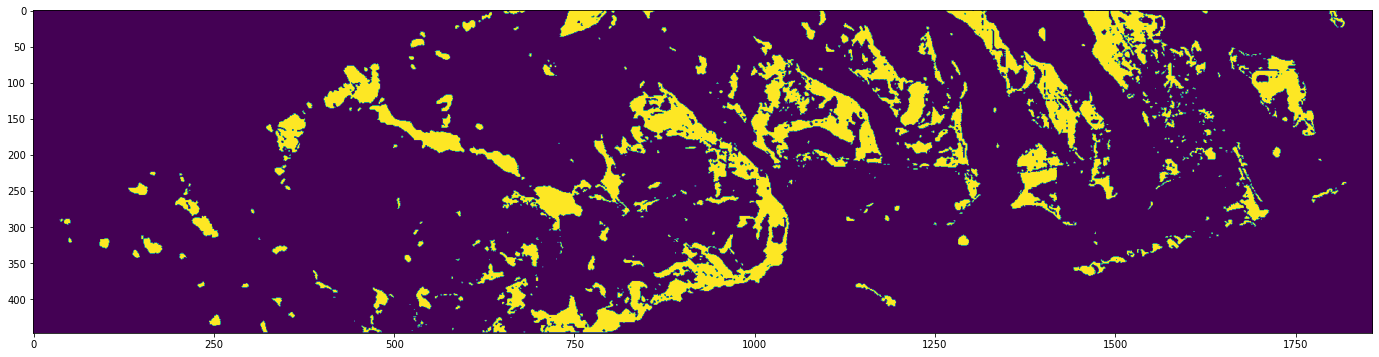

In [208]:
plt.figure(figsize=(24,6))
plt.imshow(labels_test)
# plt.colorbar()
plt.show()

In [209]:
# change dimensions of input
features_test_input = changeDimension(features_test)
labels_test_input = changeDimension(labels_test)

print(features_test_input.shape)
print(labels_test_input.shape)


(830079,)
(830079,)


In [210]:
predicted_test_image = model.predict(features_test_input)
predicted_test_image = predicted_test_image[:,1]

In [211]:
# convert to 1 or 0 if above threshold
predicted_test_image_aboveThresh = (predicted_test_image>0.2).astype(int)

In [212]:
cMatrix = confusion_matrix(labels_test_input, predicted_test_image_aboveThresh)
pScore = precision_score(labels_test_input, predicted_test_image_aboveThresh)
rScore = recall_score(labels_test_input, predicted_test_image_aboveThresh)
aScore = accuracy_score(labels_test_input, predicted_test_image_aboveThresh)
f1Score = f1_score(labels_test_input, predicted_test_image_aboveThresh)

print("Confusion matrix:\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f" % (pScore, rScore))
print('Accuracy: %.3f' % (aScore))
print('f1: %.3f' % (f1Score))

print(classification_report(yTest, yTest_pred))


Confusion matrix:
 [[723534  16929]
 [ 18946  70670]]

P-Score: 0.807, R-Score: 0.789
Accuracy: 0.957
f1: 0.798
              precision    recall  f1-score   support

           0       0.98      0.96      0.97    233200
           1       0.91      0.96      0.94     98089

    accuracy                           0.96    331289
   macro avg       0.95      0.96      0.95    331289
weighted avg       0.96      0.96      0.96    331289



In [213]:
prediction_test_image_2d = np.reshape(predicted_test_image_aboveThresh, (ds_labels_test.RasterYSize-1, ds_labels_test.RasterXSize)) # need the -1 since I removed the top row

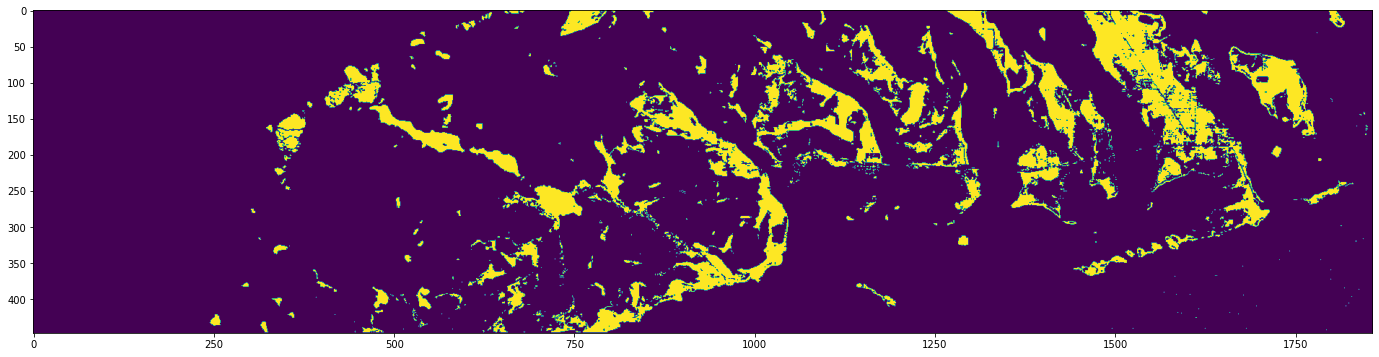

In [214]:
plt.figure(figsize=(24,6))
plt.imshow(prediction_test_image_2d)
# plt.colorbar()
plt.show()

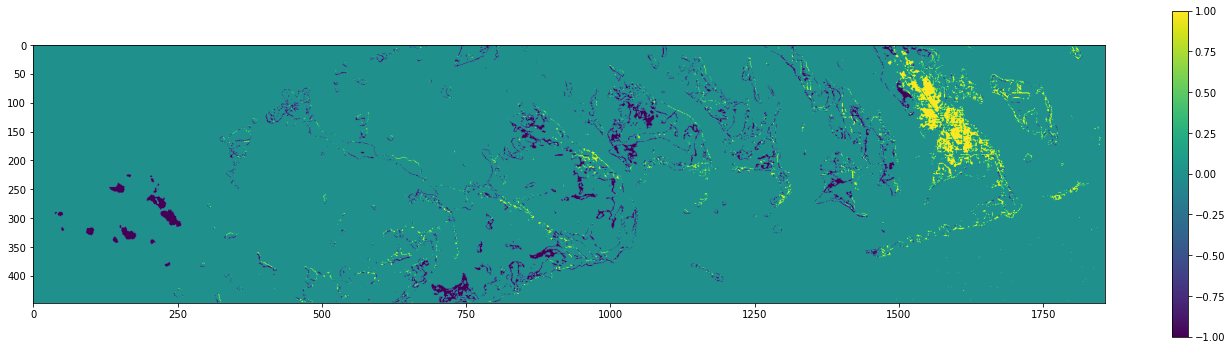

In [215]:
image_difference = prediction_test_image - labels_test
plt.figure(figsize=(24,6))
plt.imshow(image_difference)
plt.colorbar()
plt.show()